In [1]:
!pip install prophet


## 1. Import libraries

In [520]:
#import needed libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric


## 2. Uploading and preparing the data 

In [521]:
#data_set.  Clean data WITHOUT outliers 
data = pd.read_csv('data_no_outliers.csv')



In [522]:
#data setting index
data = data.set_index('Txn_date')
data.index = pd.to_datetime(data.index)
data = data.sort_index()


In [523]:
total_sales = data.resample('D').sum().reset_index()

/var/folders/wd/2sf_363j2qgdyy46qr3rysph0000gn/T/ipykernel_12498/2519079710.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_sales = data.resample('D').sum().reset_index()


In [524]:
# Total sales by date
total_sales = data.groupby('Txn_date')['Total_Amt'].sum()

In [525]:
total_sales

Txn_date
2016-01-02    60124.155
2016-01-03    32711.315
2016-01-04    69406.155
2016-01-05    60425.820
2016-01-06    41829.775
                ...    
2018-12-27    43524.845
2018-12-28    45940.375
2018-12-29    45063.005
2018-12-30    50402.365
2018-12-31    43497.220
Name: Total_Amt, Length: 1071, dtype: float64

In [526]:
# prepare data for Prophet
prophet_data = total_sales.reset_index()
prophet_data.columns = ['ds', 'y']

## 3. Train and Prophet model


In [527]:
# Initialize the Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.05)


# adding custom weekly seasonality
model.add_seasonality(name='monthly', period=30, fourier_order=5)


In [528]:
# Fit the model to the data
model.fit(prophet_data)

15:13:59 - cmdstanpy - INFO - Chain [1] start processing
15:13:59 - cmdstanpy - INFO - Chain [1] done processing


## 4. Future predictions 365

In [529]:
# Create a dataframe for future dates (365 days)
future = model.make_future_dataframe(periods=365)

# Predict
forecast = model.predict(future)


In [530]:
# Predict
forecast = model.predict(future)

In [531]:
forecast.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-02,57591.907323,32384.584437,66795.180619,57591.907323,57591.907323,-8817.939228,-8817.939228,-8817.939228,-10040.978723,...,792.024333,792.024333,792.024333,2026.536819,2026.536819,2026.536819,0.0,0.0,0.0,48773.968095
1,2016-01-03,57591.486162,30952.597719,65819.732375,57591.486162,57591.486162,-8868.193176,-8868.193176,-8868.193176,-10040.978723,...,343.812110,343.812110,343.812110,1791.310807,1791.310807,1791.310807,0.0,0.0,0.0,48723.292986
2,2016-01-04,57591.065002,32726.730608,67139.434236,57591.065002,57591.065002,-8163.791487,-8163.791487,-8163.791487,-10040.978723,...,48.469523,48.469523,48.469523,1496.194492,1496.194492,1496.194492,0.0,0.0,0.0,49427.273515
3,2016-01-05,57590.643841,33279.486162,67772.826602,57590.643841,57590.643841,-7574.525330,-7574.525330,-7574.525330,-10040.978723,...,167.394188,167.394188,167.394188,1145.427645,1145.427645,1145.427645,0.0,0.0,0.0,50016.118512
4,2016-01-06,57590.222680,32256.992861,66010.574257,57590.222680,57590.222680,-9102.913803,-9102.913803,-9102.913803,-10040.978723,...,-650.652451,-650.652451,-650.652451,744.834013,744.834013,744.834013,0.0,0.0,0.0,48487.308878


## 5. Plotting the results for the forecast

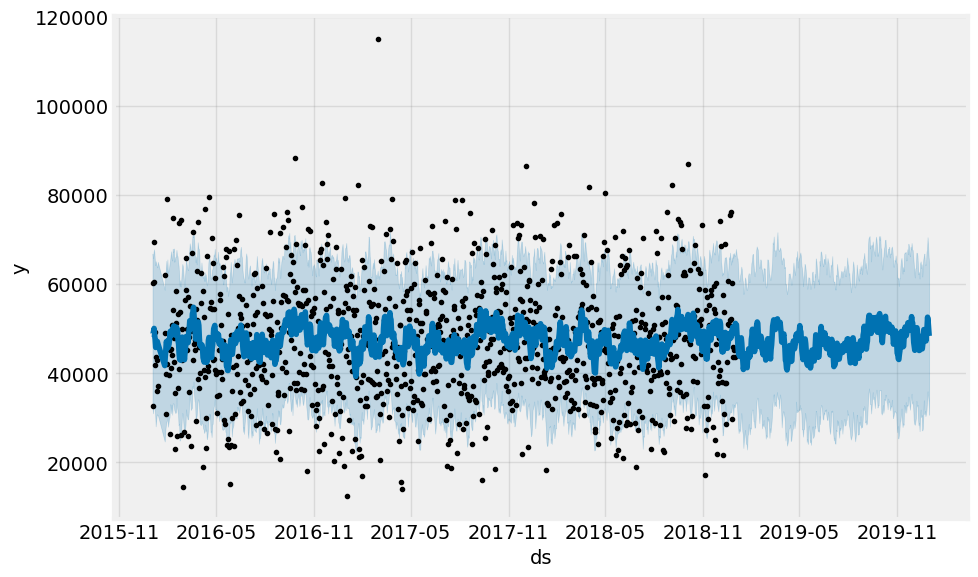

In [532]:
# Plotting
fig1 = model.plot(forecast)


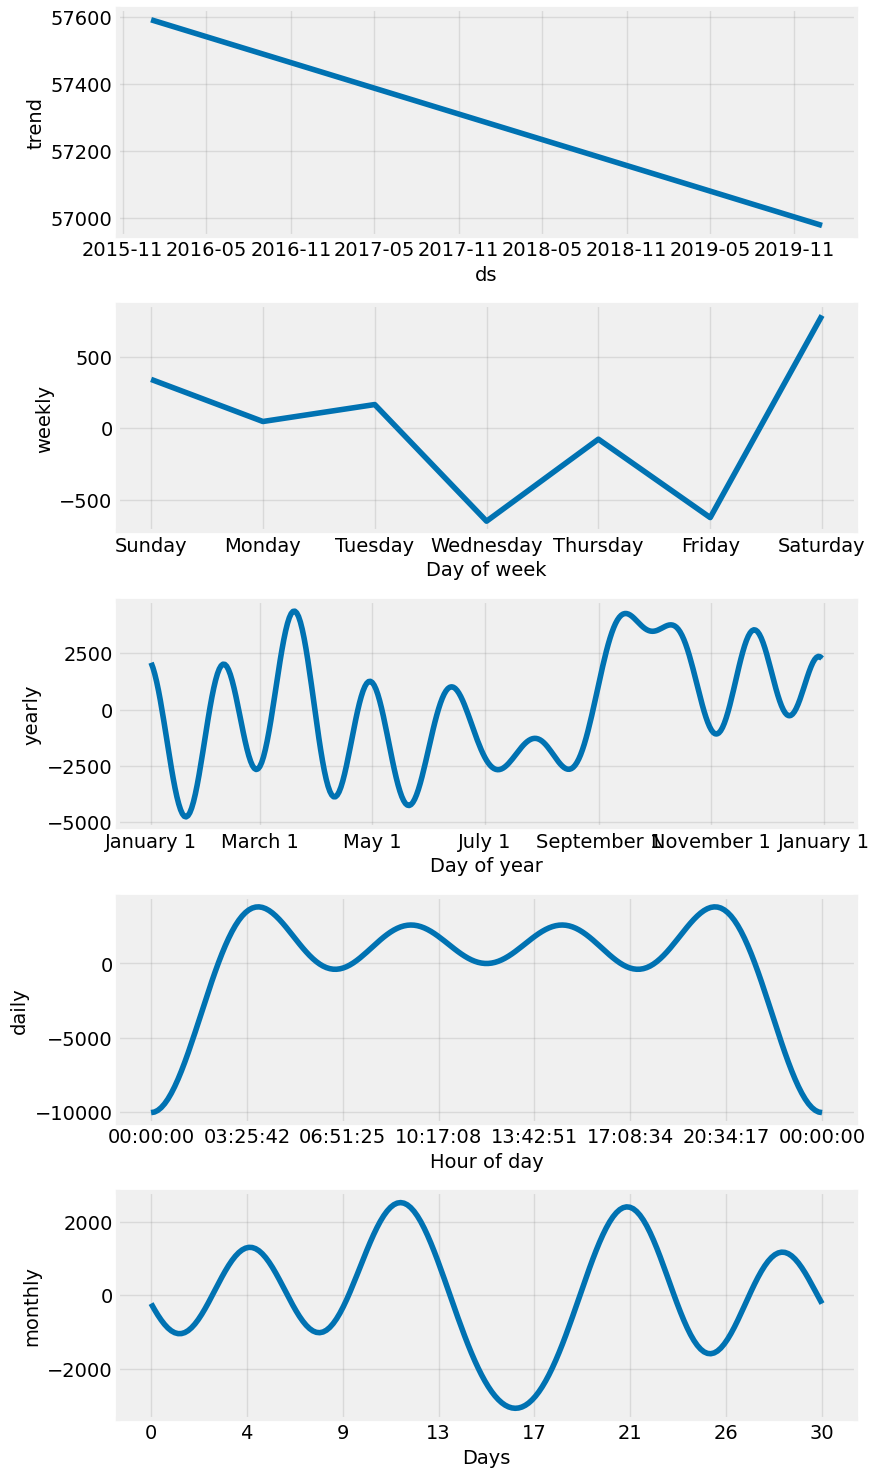

In [533]:
fig2 = model.plot_components(forecast)

## 6. Cross validation and additional metrics

In [534]:
#prep for cross validation
total_days = len(prophet_data)
total_days

1071

In [535]:
max_init = total_days - 365
max_init

706

In [536]:
# Create cross-validated forecast
df_cv = cross_validation(model, initial='706 days', period='180 days', horizon='365 days')


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:01 - cmdstanpy - INFO - Chain [1] start processing
15:14:01 - cmdstanpy - INFO - Chain [1] done processing


In [537]:
# Compute performance metrics
df_p = performance_metrics(df_cv)

In [562]:
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,1.672413e+08,12932.181771,10010.231202,0.233718,0.202322,0.217238,0.833333
1,37 days,1.689182e+08,12996.852369,10071.249064,0.231061,0.202322,0.216651,0.833333
2,38 days,1.721979e+08,13122.420119,10205.957992,0.233120,0.218837,0.219186,0.833333
3,39 days,1.919052e+08,13852.984457,10895.354119,0.241798,0.231360,0.229989,0.805556
4,40 days,1.821526e+08,13496.392202,10526.393948,0.237400,0.218837,0.224524,0.833333


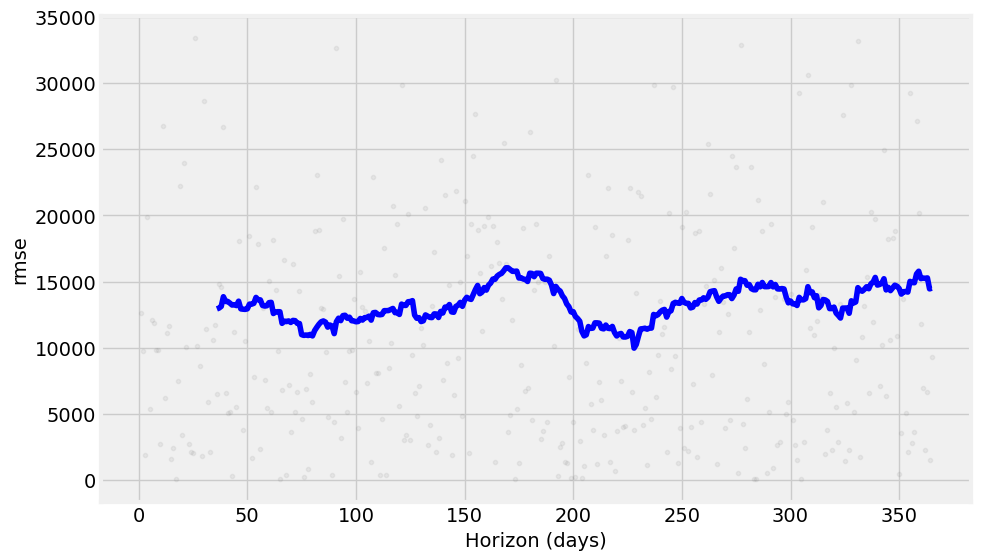

In [539]:
# Plot the RMSE
fig = plot_cross_validation_metric(df_cv, metric='rmse')

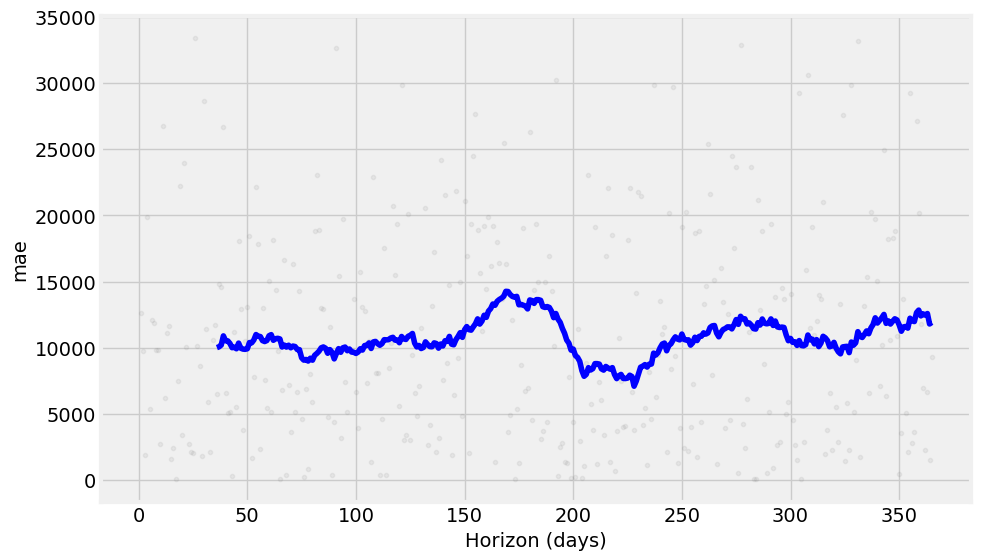

In [540]:
# Plot the MAE
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [541]:
df_p = performance_metrics(df_cv)
print(df_p.head())

  horizon           mse          rmse           mae      mape     mdape  \
0 36 days  1.672413e+08  12932.181771  10010.231202  0.233718  0.202322   
1 37 days  1.689182e+08  12996.852369  10071.249064  0.231061  0.202322   
2 38 days  1.721979e+08  13122.420119  10205.957992  0.233120  0.218837   
3 39 days  1.919052e+08  13852.984457  10895.354119  0.241798  0.231360   
4 40 days  1.821526e+08  13496.392202  10526.393948  0.237400  0.218837   

      smape  coverage  
0  0.217238  0.833333  
1  0.216651  0.833333  
2  0.219186  0.833333  
3  0.229989  0.805556  
4  0.224524  0.833333  


## 7.RMSE CHECK

In [553]:
train = prophet_data.iloc[:-365]
test = prophet_data.iloc[-365:]

In [555]:
# 1. dummy forecast
dummy_forecast = [train['y'].iloc[-1]] * len(test)
rmse_dummy = np.sqrt(mean_squared_error(test['y'], dummy_forecast))
mae_dummy = mean_absolute_error(test['y'], dummy_forecast)

In [556]:
# 2. Historical Average
historical_avg = [train['y'].mean()] * len(test)
rmse_avg = np.sqrt(mean_squared_error(test['y'], historical_avg))
mae_avg = mean_absolute_error(test['y'], historical_avg)

In [557]:
rmse_dummy, mae_dummy, rmse_avg, mae_avg

(13300.269727449404,
 10641.467876712328,
 13142.327431083175,
 10413.278794481743)

## 8. Plotting the Time Series Forecast Comapison

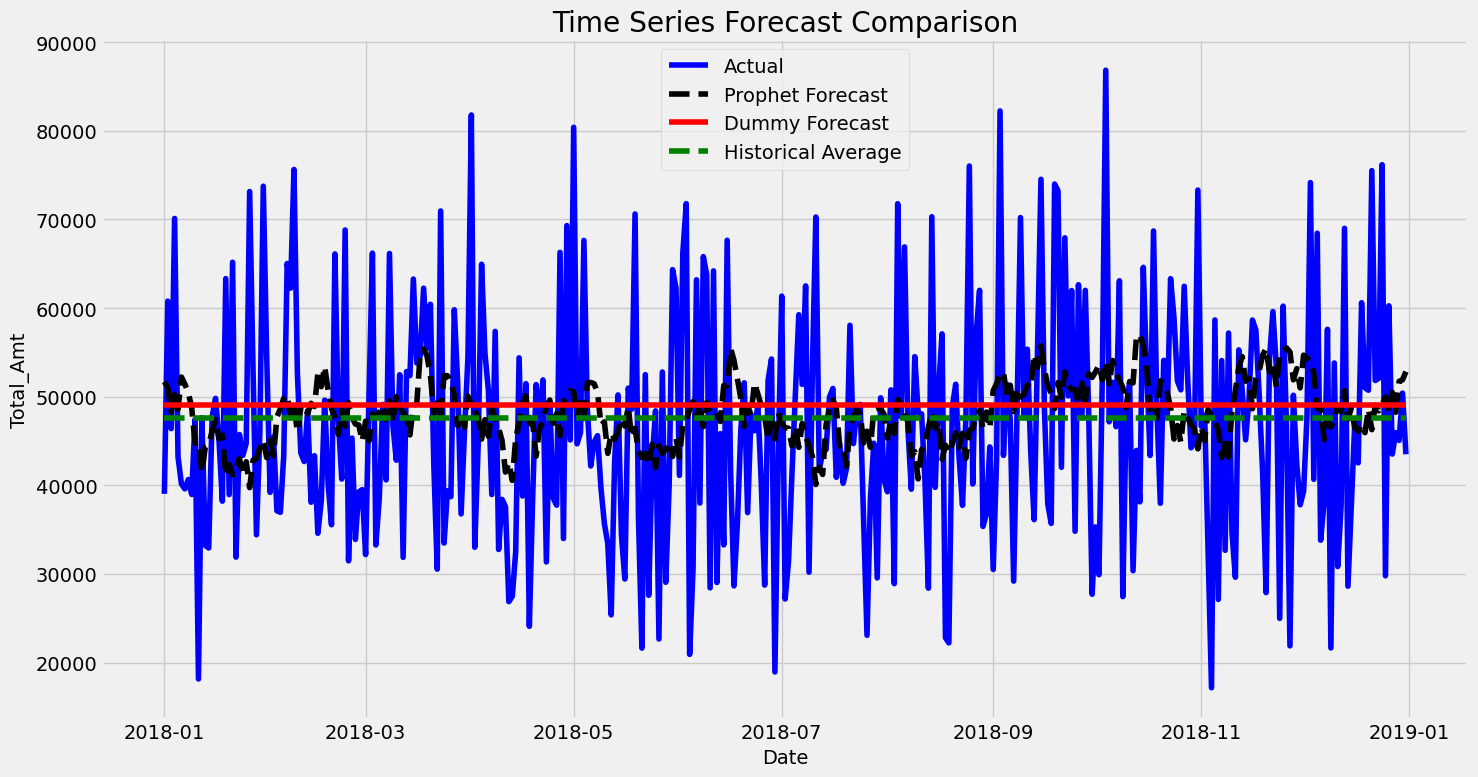

In [546]:
plt.figure(figsize=(15, 8))

#Actual data
plt.plot(test['ds'], test['y'], label='Actual', color='blue')

# Prophet forecast 
prophet_forecast = df_cv[df_cv['ds'].isin(test['ds'])]['yhat']
plt.plot(test['ds'], prophet_forecast, label='Prophet Forecast', color='black', linestyle='--')

# Dummy forecast
plt.plot(test['ds'], dummy_forecast, label='Dummy Forecast', color='red', linestyle='-')

# Historical average
plt.plot(test['ds'], historical_avg, label='Historical Average', color='green', linestyle='--')

plt.title('Time Series Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Total_Amt')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## 9. Comparison Prohet forecas values with Total_Amt

In [558]:
#getting daily total
data_agg = data.groupby('Txn_date').sum()['Total_Amt'].reset_index()

/var/folders/wd/2sf_363j2qgdyy46qr3rysph0000gn/T/ipykernel_12498/2974526819.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_agg = data.groupby('Txn_date').sum()['Total_Amt'].reset_index()


In [559]:
#merging aggregated datawith forecast
merged_prophet = forecast[['ds', 'yhat']].merge(data_agg, left_on='ds', right_on='Txn_date', how='inner')


In [560]:
#Calc sq diff
merged_prophet['squared_diff'] = (merged_prophet['yhat'] - merged_prophet['Total_Amt']) ** 2


In [561]:
#calc RMSE for the forecast
rmse_prophet = np.sqrt(merged_prophet['squared_diff'].mean())
print(rmse_prophet)


13380.729326117837
